In [36]:

from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan


In [37]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [38]:
from genetic_alg_lib.gene import gene 

allowed_bodies = ["Ganymede"]
encounter_bodies = ["Ganymede","Ganymede"]

body = np.random.choice(allowed_bodies)


test_gene_1 = gene(Jupiter,allowed_bodies,2)
test_gene_1.generate_gene_randomly(500)
test_gene_1.bodies=encounter_bodies

print(test_gene_1.first_date)
print(test_gene_1.epochs)
print(test_gene_1.last_date)


test_gene_2 = gene(Jupiter,allowed_bodies,2)
test_gene_2.generate_gene_randomly(500)
test_gene_2.bodies=encounter_bodies 
test_gene_baby = test_gene_1.make_baby_fixed_bodies(test_gene_2)
# print(test_gene_baby.epochs)

177.77616383127625
[363.509418123371, 477.62720121034744]
478.97205733870413


In [39]:

NAME_TO_BODY = {
    "Io": Io,
    "Europa": Europa,
    "Ganymede": Ganymede,
    "Callisto": Callisto,
    "Jupiter": Jupiter,
    # add more as needed
}

BODY_TO_NUM = {
    Io: 501,
    Europa: 502,
    Ganymede: 503,
    Callisto: 504,
    Jupiter: 599,
    # add more as needed
}

def str_to_bod(name: str) -> Body:
    try:
        return NAME_TO_BODY[name]
    except KeyError as e:
        raise KeyError(f"Unknown body name {name!r}. Known: {list(NAME_TO_BODY.keys())}") from e

def bod_to_num(body: Body) -> int:
    try:
        return BODY_TO_NUM[body]
    except KeyError as e:
        raise KeyError(f"Unknown body {body}. Known: {list(BODY_TO_NUM.keys())}") from e
    
    



In [40]:
sim_start_date = time.Time("2037-07-16 15:01", scale="utc").tdb
sim_end_date = time.Time("2038-07-25 01:01", scale="utc").tdb
epoch=time_range(start=sim_start_date, end=sim_end_date)

io_ephem = Ephem.from_horizons(501,epochs= epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Io is 501
europa_ephem = Ephem.from_horizons(502,epochs= epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Europa is 502
ganymede_ephem = Ephem.from_horizons(503,epochs= epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
callisto_ephem = Ephem.from_horizons(504,epochs= epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Callisto is 504

BODY_TO_EPHEM = {
    Io: io_ephem,
    Europa: europa_ephem,   
    Ganymede: ganymede_ephem,
    Callisto: callisto_ephem,
}   

def bod_to_ephem(body: Body) -> Ephem:
    try:
        return BODY_TO_EPHEM[body]
    except KeyError as e:
        raise KeyError(f"Unknown body {body}. Known: {list(BODY_TO_EPHEM.keys())}") from e
    


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



86407.13029942125


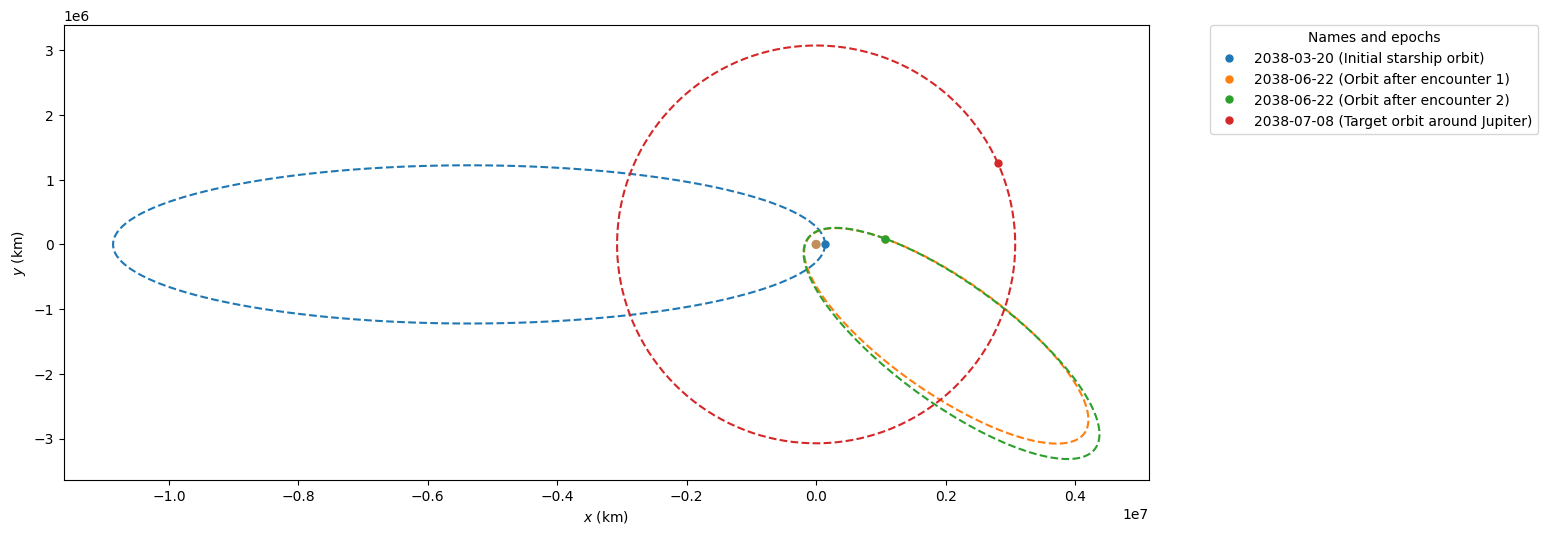

In [47]:


def calculate_fitness_and_plot(gene_obj, target_alt=3004000*u.km):
    """
    Calculate fitness for a gene object.
    
    Parameters:
    gene_obj: gene object with bodies, epochs, rps, progades, first_date, last_date
    target_alt: target altitude for final orbit (default 504000 km)
    
    Returns:
    total_dv: total delta-v required for the mission
    """
    encounters = gene_obj.encounters
    plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

    # Convert first body name to Body object and get ephemeris
    first_body = str_to_bod(gene_obj.bodies[0])
    first_body_num = bod_to_num(first_body)
    
    # Create epoch range for ephemeris
    epoch_start = sim_start_date + gene_obj.first_date * u.day
    epoch_end = sim_start_date + gene_obj.last_date * u.day
    epoch_range = time_range(start=epoch_start, end=epoch_end)
    
    # Get ephemeris for first body
    body_ephem = bod_to_ephem(first_body)
    # print(f"Time range is {epoch_start} to {epoch_end}, first encounter at {sim_start_date + gene_obj.epochs[0] * u.day}")
    # First encounter time
    first_encounter_time = sim_start_date + gene_obj.epochs[0] * u.day
    body_orb = Orbit.from_ephem(Jupiter, body_ephem, first_encounter_time)
    
    # Initial starship orbit
    start_time = sim_start_date + gene_obj.first_date * u.day
    starship_orb = Orbit.from_classical(Jupiter, 5500000*u.km, 0.975*u.one, 
                                        body_orb.inc, body_orb.raan, 0*u.deg, 0*u.deg,
                                        start_time, plane=Planes.EARTH_ECLIPTIC)
    
    # First Lambert arc to first encounter
    ss_arrival = Orbit.from_ephem(Jupiter, body_ephem, first_encounter_time)
    man_lambert_0 = Maneuver.lambert(starship_orb, ss_arrival)
    burn1_dv = np.linalg.norm(man_lambert_0[0][1])
    
    post_burn_orb = starship_orb.apply_maneuver(man_lambert_0, intermediate=True)[0]
    op_orb = post_burn_orb.propagate(ss_arrival.epoch - post_burn_orb.epoch)
    
    total_dv = burn1_dv
    
    # Loop through remaining encounters (except the last one)
    for i in range(0, encounters - 1):
        # Get current body and ephemeris
        body = str_to_bod(gene_obj.bodies[i])
        body_num = bod_to_num(body)
        body_ephem = bod_to_ephem(body)

        # Current encounter time
        encounter_time = sim_start_date + gene_obj.epochs[i] * u.day
        # Next encounter time
        next_encounter_time = sim_start_date + gene_obj.epochs[i+1] * u.day
        
        # Get body orbit at encounter
        orb_body = Orbit.from_ephem(Jupiter, body_ephem, encounter_time)
        
        # Calculate gravity assist
        arrival_vel = op_orb.rv()[1] - orb_body.rv()[1]
        arrival_speed = np.linalg.norm(arrival_vel)
        
        r_p = body.R + gene_obj.rps[i] * u.km
        
        # Calculate deflection angle
        flip_sin = 1 / (1 + r_p * arrival_speed**2 / body.k)
        # Use progade boolean to determine sign (True = 1, False = -1)
        sign = 1 if gene_obj.progades[i] else -1
        angle = sign * math.asin(flip_sin * 2)
        
        # Apply rotation to velocity vector
        rot = scipyRot.from_euler('z', angle, degrees=False)
        vel_vector_1 = rot.apply(arrival_vel.value) * u.km/u.s
        v_final = vel_vector_1 + orb_body.rv()[1]
        op_orb = Orbit.from_vectors(Jupiter, orb_body.rv()[0], v_final, 
                                    epoch=encounter_time, plane=Planes.EARTH_ECLIPTIC)
        
        # Get next body for next encounter
        next_body = str_to_bod(gene_obj.bodies[i+1])
        next_body_num = bod_to_num(next_body)
        next_body_ephem = bod_to_ephem(next_body)
        next_orb_body = Orbit.from_ephem(Jupiter, next_body_ephem, next_encounter_time)
        
        # Lambert arc to next encounter
        man_lambert = Maneuver.lambert(op_orb, next_orb_body, M=0)
        burn_dv = np.linalg.norm(man_lambert[0][1])
        total_dv += burn_dv
        
        trans_orb = op_orb.apply_maneuver(man_lambert, intermediate=True)[0]
        op_orb = trans_orb.propagate(next_encounter_time - encounter_time)
    
    # Final encounter
    final_body = str_to_bod(gene_obj.bodies[encounters-1])
    final_body_num = bod_to_num(final_body)
    final_body_ephem = bod_to_ephem(final_body)
    final_encounter_time = sim_start_date + gene_obj.epochs[encounters-1] * u.day
    final_orb_body = Orbit.from_ephem(Jupiter, final_body_ephem, final_encounter_time)
    
    # Final gravity assist
    arrival_vel = op_orb.rv()[1] - final_orb_body.rv()[1]
    arrival_speed = np.linalg.norm(arrival_vel)
    r_p = final_body.R + gene_obj.rps[encounters-1] * u.km
    flip_sin = 1 / (1 + r_p * arrival_speed**2 / final_body.k)
    sign = 1 if gene_obj.progades[encounters-1] else -1
    angle = sign * math.asin(flip_sin * 2)
    
    rot = scipyRot.from_euler('z', angle, degrees=False)
    vel_vector_1 = rot.apply(arrival_vel.value) * u.km/u.s
    v_final = vel_vector_1 + final_orb_body.rv()[1]
    
    final_orb = Orbit.from_vectors(Jupiter, final_orb_body.rv()[0], v_final, 
                                   epoch=final_encounter_time, plane=Planes.EARTH_ECLIPTIC)
    
    # Final burn to target orbit
    final_arrival_time = sim_start_date + gene_obj.last_date * u.day
    target_orb = Orbit.circular(Jupiter, alt=target_alt, epoch=final_arrival_time, 
                                plane=Planes.EARTH_ECLIPTIC)
    man_lambert = Maneuver.lambert(final_orb, target_orb, M=0)
    sv_burn_dv = np.linalg.norm(man_lambert[0][1])
    circ_burn_dv = np.linalg.norm(man_lambert[1][1])
    total_dv += sv_burn_dv + circ_burn_dv
    
    plotter.plot(starship_orb, label="Initial starship orbit")
    plotter.plot(op_orb, label=f"Orbit after encounter {encounters-1}")
    plotter.plot(final_orb, label=f"Orbit after encounter {encounters}")
    # plotter.plot(trans_orb, label=f"Final orbit after second last burn")
    plotter.plot(target_orb, label="Target orbit around Jupiter")
    
    return total_dv.value


test_gene_1 = gene(Jupiter,allowed_bodies,2)
test_gene_1.generate_gene_randomly(365)
test_gene_1.bodies=encounter_bodies
fitness_1 = print(calculate_fitness_and_plot(test_gene_1))

In [42]:
# plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)


def calculate_fitness(gene_obj, target_alt=3004000*u.km):
    """
    Calculate fitness for a gene object.
    
    Parameters:
    gene_obj: gene object with bodies, epochs, rps, progades, first_date, last_date
    target_alt: target altitude for final orbit (default 504000 km)
    
    Returns:
    total_dv: total delta-v required for the mission
    """
    encounters = gene_obj.encounters
    
    # Convert first body name to Body object and get ephemeris
    first_body = str_to_bod(gene_obj.bodies[0])
    first_body_num = bod_to_num(first_body)
    
    # Create epoch range for ephemeris
    epoch_start = sim_start_date + gene_obj.first_date * u.day
    epoch_end = sim_start_date + gene_obj.last_date * u.day
    epoch_range = time_range(start=epoch_start, end=epoch_end)
    
    # Get ephemeris for first body
    body_ephem = bod_to_ephem(first_body)
    # print(f"Time range is {epoch_start} to {epoch_end}, first encounter at {sim_start_date + gene_obj.epochs[0] * u.day}")
    # First encounter time
    first_encounter_time = sim_start_date + gene_obj.epochs[0] * u.day
    body_orb = Orbit.from_ephem(Jupiter, body_ephem, first_encounter_time)
    
    # Initial starship orbit
    start_time = sim_start_date + gene_obj.first_date * u.day
    starship_orb = Orbit.from_classical(Jupiter, 5500000*u.km, 0.975*u.one, 
                                        body_orb.inc, body_orb.raan, 0*u.deg, 0*u.deg,
                                        start_time, plane=Planes.EARTH_ECLIPTIC)
    
    # First Lambert arc to first encounter
    ss_arrival = Orbit.from_ephem(Jupiter, body_ephem, first_encounter_time)
    man_lambert_0 = Maneuver.lambert(starship_orb, ss_arrival)
    burn1_dv = np.linalg.norm(man_lambert_0[0][1])
    
    post_burn_orb = starship_orb.apply_maneuver(man_lambert_0, intermediate=True)[0]
    op_orb = post_burn_orb.propagate(ss_arrival.epoch - post_burn_orb.epoch)
    
    total_dv = burn1_dv
    
    # Loop through remaining encounters (except the last one)
    for i in range(0, encounters - 1):
        # Get current body and ephemeris
        body = str_to_bod(gene_obj.bodies[i])
        body_num = bod_to_num(body)
        body_ephem = bod_to_ephem(body)

        # Current encounter time
        encounter_time = sim_start_date + gene_obj.epochs[i] * u.day
        # Next encounter time
        next_encounter_time = sim_start_date + gene_obj.epochs[i+1] * u.day
        
        # Get body orbit at encounter
        orb_body = Orbit.from_ephem(Jupiter, body_ephem, encounter_time)
        
        # Calculate gravity assist
        arrival_vel = op_orb.rv()[1] - orb_body.rv()[1]
        arrival_speed = np.linalg.norm(arrival_vel)
        
        r_p = body.R + gene_obj.rps[i] * u.km
        
        # Calculate deflection angle
        flip_sin = 1 / (1 + r_p * arrival_speed**2 / body.k)
        # Use progade boolean to determine sign (True = 1, False = -1)
        sign = 1 if gene_obj.progades[i] else -1
        angle = sign * math.asin(flip_sin * 2)
        
        # Apply rotation to velocity vector
        rot = scipyRot.from_euler('z', angle, degrees=False)
        vel_vector_1 = rot.apply(arrival_vel.value) * u.km/u.s
        v_final = vel_vector_1 + orb_body.rv()[1]
        op_orb = Orbit.from_vectors(Jupiter, orb_body.rv()[0], v_final, 
                                    epoch=encounter_time, plane=Planes.EARTH_ECLIPTIC)
        
        # Get next body for next encounter
        next_body = str_to_bod(gene_obj.bodies[i+1])
        next_body_num = bod_to_num(next_body)
        next_body_ephem = bod_to_ephem(next_body)
        next_orb_body = Orbit.from_ephem(Jupiter, next_body_ephem, next_encounter_time)
        
        # Lambert arc to next encounter
        man_lambert = Maneuver.lambert(op_orb, next_orb_body, M=0)
        burn_dv = np.linalg.norm(man_lambert[0][1])
        total_dv += burn_dv
        
        trans_orb = op_orb.apply_maneuver(man_lambert, intermediate=True)[0]
        op_orb = trans_orb.propagate(next_encounter_time - encounter_time)
    
    # Final encounter
    final_body = str_to_bod(gene_obj.bodies[encounters-1])
    final_body_num = bod_to_num(final_body)
    final_body_ephem = bod_to_ephem(final_body)
    final_encounter_time = sim_start_date + gene_obj.epochs[encounters-1] * u.day
    final_orb_body = Orbit.from_ephem(Jupiter, final_body_ephem, final_encounter_time)
    
    # Final gravity assist
    arrival_vel = op_orb.rv()[1] - final_orb_body.rv()[1]
    arrival_speed = np.linalg.norm(arrival_vel)
    r_p = final_body.R + gene_obj.rps[encounters-1] * u.km
    flip_sin = 1 / (1 + r_p * arrival_speed**2 / final_body.k)
    sign = 1 if gene_obj.progades[encounters-1] else -1
    angle = sign * math.asin(flip_sin * 2)
    
    rot = scipyRot.from_euler('z', angle, degrees=False)
    vel_vector_1 = rot.apply(arrival_vel.value) * u.km/u.s
    v_final = vel_vector_1 + final_orb_body.rv()[1]
    
    final_orb = Orbit.from_vectors(Jupiter, final_orb_body.rv()[0], v_final, 
                                   epoch=final_encounter_time, plane=Planes.EARTH_ECLIPTIC)
    
    # Final burn to target orbit
    final_arrival_time = sim_start_date + gene_obj.last_date * u.day
    target_orb = Orbit.circular(Jupiter, alt=target_alt, epoch=final_arrival_time, 
                                plane=Planes.EARTH_ECLIPTIC)
    man_lambert = Maneuver.lambert(final_orb, target_orb, M=0)
    sv_burn_dv = np.linalg.norm(man_lambert[0][1])
    circ_burn_dv = np.linalg.norm(man_lambert[1][1])
    total_dv += sv_burn_dv + circ_burn_dv
    
    # plotter.plot(starship_orb, label="Initial starship orbit")
    # plotter.plot(op_orb, label=f"Orbit after encounter {encounters-1}")
    # plotter.plot(final_orb, label=f"Orbit after encounter {encounters}")
    # # plotter.plot(trans_orb, label=f"Final orbit after second last burn")
    # plotter.plot(target_orb, label="Target orbit around Jupiter")
    
    return total_dv.value


test_gene_1 = gene(Jupiter,allowed_bodies,2)
test_gene_1.generate_gene_randomly(365)
test_gene_1.bodies=encounter_bodies
fitness_1 = print(calculate_fitness(test_gene_1))

81218.25653472844


In [48]:
population_size = 10
population = []
allowed_bodies = ["Ganymede"]
tries = 50

#order of encounters
encounter_bodies = ["Ganymede","Ganymede"]
for _ in range(population_size):
    gene_individual = gene(Jupiter, allowed_bodies, 4)
    gene_individual.generate_gene_randomly(365)
    gene_individual.bodies = encounter_bodies
    population.append(gene_individual)
print(population[0].bodies)
best_gene= population[0]
best_gene_cost = calculate_fitness(population[0])  

for _ in range(tries):
    fitness_landscape = np.zeros(population_size)
    for i, individual in enumerate(population):
        try:
            dv_cost = calculate_fitness(individual)
            if dv_cost < best_gene_cost:
                best_gene = individual
                best_gene_cost = dv_cost
                print(f"New best gene found: Individual {i+1} with Fitness (Total Δv) = {dv_cost:.2f}")
            fitness_landscape[i] = 1/dv_cost
            # print(f"Individual {i+1}: Fitness (Total Δv) = {fitness:.2f}")
        except Exception as e:
            print("Runt gene; encountered an error:", e)
    #normalize fitness landscape
    fitness_landscape /= np.sum(fitness_landscape)
    # print(fitness_landscape)
    #generate next generation
    new_population = []
    for _ in range(population_size):
        parents = np.random.choice(population, size=2, p=fitness_landscape, replace=False)
        child = parents[0].make_baby_fixed_bodies(parents[1])
        new_population.append(child)
    population = new_population
    # print(f"New population size {len(population)} generated.")
    print(f"Best gene after generation with Fitness (Total Δv) = {best_gene_cost:.2f}")
    
calculate_fitness_and_plot(best_gene)

['Ganymede', 'Ganymede']


IndexError: list index out of range